In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import norm
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Set seed
np.random.seed(42)

# Simulation parameters
N_sim = 1000  # Number of Monte Carlo simulations
n = 300  # Sample size per simulation
k_folds = 2  # Number of folds for cross-fitting
N_population = 10000  # Large dataset for sampling

# Generate large dataset
X_pop = np.random.uniform(-np.pi, np.pi, size=(N_population, 10))
X_pop_df = pd.DataFrame(X_pop, columns=[f'X{i+1}' for i in range(10)])
e_X_pop = norm.cdf(np.sin(X_pop[:, 0]))
W_pop = np.random.binomial(1, e_X_pop)
epsilon_pop = np.random.normal(0, 1, N_population)
Y_1_pop = np.sin(X_pop[:, 0]) + epsilon_pop
Y_0_pop = np.cos(X_pop[:, 0] + (1 / (2 * np.pi))) + epsilon_pop
Y_pop = W_pop * Y_1_pop + (1 - W_pop) * Y_0_pop
true_tau = np.sin(X_pop[:, 0]) - np.cos(X_pop[:, 0] + (1 / (2 * np.pi)))

# Storage for results
results = []

In [48]:
# Monte Carlo Simulation
for sim in range(N_sim):
    # Sample data from large population
    sample_idx = np.random.choice(N_population, n, replace=False)
    X_df = X_pop_df.iloc[sample_idx].reset_index(drop=True)
    W = W_pop[sample_idx]
    Y = Y_pop[sample_idx]

    # IPW Estimator
    rf_propensity = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1)
    rf_propensity.fit(X_df, W)
    e_X_rf = rf_propensity.predict_proba(X_df)[:, 1]
    ipw_rf = np.mean((W * Y / e_X_rf) - ((1 - W) * Y / (1 - e_X_rf)))

    xgb_propensity = XGBClassifier(n_estimators=30, max_depth=3, eval_metric='logloss', random_state=42)
    xgb_propensity.fit(X_df, W)
    e_X_xgb = xgb_propensity.predict_proba(X_df)[:, 1]
    ipw_xgb = np.mean((W * Y / e_X_xgb) - ((1 - W) * Y / (1 - e_X_xgb)))

    # Regression Adjustment (OLS)
    X_adj = X_adj = sm.add_constant(pd.concat(objs=[pd.Series(W, name="W"), X_df], axis=1))
    model = sm.OLS(Y, X_adj).fit()
    ols_tau = model.params["W"]

    # AIPW Without Cross-Fitting
    rf_Y1, rf_Y0 = RandomForestRegressor(n_estimators=30, max_depth=3, random_state=42, n_jobs=-1), RandomForestRegressor(n_estimators=30, max_depth=3, random_state=42, n_jobs=-1)
    xgb_Y1, xgb_Y0 = XGBRegressor(n_estimators=30, max_depth=3, random_state=42), XGBRegressor(n_estimators=30, max_depth=3, random_state=42)

    treated, control = X_df[W == 1], X_df[W == 0]
    Y_treated, Y_control = Y[W == 1], Y[W == 0]

    if len(treated) > 0 and len(control) > 0:
        rf_Y1.fit(treated, Y_treated)
        rf_Y0.fit(control, Y_control)
        xgb_Y1.fit(treated, Y_treated)
        xgb_Y0.fit(control, Y_control)

        m1_rf, m0_rf = rf_Y1.predict(X_df), rf_Y0.predict(X_df)
        m1_xgb, m0_xgb = xgb_Y1.predict(X_df), xgb_Y0.predict(X_df)
    else:
        m1_rf, m0_rf, m1_xgb, m0_xgb = np.zeros(len(X_df)), np.zeros(len(X_df)), np.zeros(len(X_df)), np.zeros(len(X_df))

    aipw_rf = np.mean((W * Y / e_X_rf) - ((1 - W) * Y / (1 - e_X_rf)) + m1_rf - m0_rf)
    aipw_xgb = np.mean((W * Y / e_X_xgb) - ((1 - W) * Y / (1 - e_X_xgb)) + m1_xgb - m0_xgb)

    # AIPW With Cross-Fitting
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    tau_rf_list, tau_xgb_list = [], []

    for train_idx, test_idx in kf.split(X_df):
        X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
        W_train, W_test = W[train_idx], W[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        rf_propensity.fit(X_train, W_train)
        e_X_rf_test = rf_propensity.predict_proba(X_test)[:, 1]
        xgb_propensity.fit(X_train, W_train)
        e_X_xgb_test = xgb_propensity.predict_proba(X_test)[:, 1]

        rf_Y1.fit(X_train[W_train == 1], Y_train[W_train == 1])
        rf_Y0.fit(X_train[W_train == 0], Y_train[W_train == 0])
        xgb_Y1.fit(X_train[W_train == 1], Y_train[W_train == 1])
        xgb_Y0.fit(X_train[W_train == 0], Y_train[W_train == 0])

        m1_rf_test, m0_rf_test = rf_Y1.predict(X_test), rf_Y0.predict(X_test)
        m1_xgb_test, m0_xgb_test = xgb_Y1.predict(X_test), xgb_Y0.predict(X_test)

        tau_rf_test = (W_test * Y_test / e_X_rf_test) - ((1 - W_test) * Y_test / (1 - e_X_rf_test)) + m1_rf_test - m0_rf_test
        tau_xgb_test = (W_test * Y_test / e_X_xgb_test) - ((1 - W_test) * Y_test / (1 - e_X_xgb_test)) + m1_xgb_test - m0_xgb_test

        tau_rf_list.append(np.mean(tau_rf_test))
        tau_xgb_list.append(np.mean(tau_xgb_test))

    aipw_rf_cross = np.mean(tau_rf_list)
    aipw_xgb_cross = np.mean(tau_xgb_list)

    # Store results
    results.append([np.mean(true_tau), ipw_rf, ipw_xgb, ols_tau, aipw_rf, aipw_xgb, aipw_rf_cross, aipw_xgb_cross])

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\yizho\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

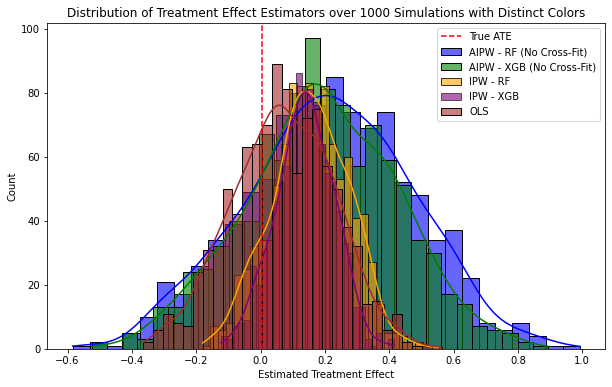

In [52]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["True_Tau", "IPW_RF", "IPW_XGB", "OLS", "AIPW_RF", "AIPW_XGB", "AIPW_RF_Cross", "AIPW_XGB_Cross"])

results_df.to_csv("F:/PhD/DSO670/simulation_results.csv", index=False)

# Calculate Bias, Variance, MSE
bias_variance_df = pd.DataFrame({
    "Estimator": ["IPW - RF", "IPW - XGB", "OLS", "AIPW - RF (No Cross-Fit)", "AIPW - XGB (No Cross-Fit)", "AIPW - RF (Cross-Fit)", "AIPW - XGB (Cross-Fit)"],
    "Bias": results_df.drop(columns="True_Tau").mean() - results_df["True_Tau"].mean(),
    "Variance": results_df.drop(columns="True_Tau").var(),
    "MSE": (results_df.drop(columns="True_Tau") - results_df["True_Tau"].values[:, None]).pow(2).mean()
})

bias_variance_df.to_csv("F:/PhD/DSO670/bias_variance_df.csv", index=False)

# 95% Wald Confidence Interval for AIPW (No Cross-Fit)
alpha = 0.05
z_score = norm.ppf(1 - alpha / 2)
aipw_se = results_df[["AIPW_RF", "AIPW_XGB"]].std()
aipw_ci = pd.DataFrame({
    "Estimator": ["AIPW - RF (No Cross-Fit)", "AIPW - XGB (No Cross-Fit)"],
    "Lower 95% CI": results_df[["AIPW_RF", "AIPW_XGB"]].mean() - z_score * aipw_se,
    "Upper 95% CI": results_df[["AIPW_RF", "AIPW_XGB"]].mean() + z_score * aipw_se
})

aipw_ci.to_csv("F:/PhD/DSO670/aipw_ci.csv", index=False)

# Improved Histogram with Distinct Colors
plt.figure(figsize=(10, 6))

# Define distinct colors for each estimator
colors = ["blue", "green", "orange", "purple", "brown", "pink"]

# Plot histogram for AIPW estimators (No Cross-Fit)
sns.histplot(results_df["AIPW_RF"], bins=30, kde=True, color=colors[0], label="AIPW - RF (No Cross-Fit)", alpha=0.6)
sns.histplot(results_df["AIPW_XGB"], bins=30, kde=True, color=colors[1], label="AIPW - XGB (No Cross-Fit)", alpha=0.6)

# Plot histogram for IPW estimators
sns.histplot(results_df["IPW_RF"], bins=30, kde=True, color=colors[2], label="IPW - RF", alpha=0.6)
sns.histplot(results_df["IPW_XGB"], bins=30, kde=True, color=colors[3], label="IPW - XGB", alpha=0.6)

# Plot histogram for OLS estimator
sns.histplot(results_df["OLS"], bins=30, kde=True, color=colors[4], label="OLS", alpha=0.6)

# True ATE reference line
plt.axvline(results_df["True_Tau"].mean(), color="red", linestyle="dashed", label="True ATE")

plt.legend()
plt.xlabel("Estimated Treatment Effect")
plt.title("Distribution of Treatment Effect Estimators over 1000 Simulations with Distinct Colors")
plt.savefig("treatment_effect_distribution.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.show()

Accross all the different method, OLS gives perform the best overall with smallest bias and relatively small variance and mean squared error.AIPW on the other hand has a larger variance and and bias compared with other method and perform poorly than others.IPW estmates on the other hand, has the smallest variace and a smaller bias than the AIPW method. This might be due to the unstability of AIPW with model misspecification in all the nuianse fuctions (only x1 matters but x1 to x10 are involved in the machine learning model). Given the large coverage of the AIPW estimator, the large variance result in a smaller probability to rejuct the null. IPW tend to estimate a postivie impact than AIPW estimators regarding inference.In the model misspecification settings, OLS perform the best.